# Import necessary libraries and define configurations

In [1]:

import os
import pickle
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, welch
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML

# Configurations
DATASET_DIR = "/kaggle/input/wesad-full-dataset/WESAD/" 
TEST_SIZE = 0.3 
WINDOW_SIZE = 80  
FILTER_CUTOFF = 0.1  
OVERLAB = 40
MAX_TREES = 100  
OUTPUT_DIR = "/kaggle/working/outputs"  

# Define helper functions for filtering and feature extraction

In [2]:
def low_pass_filter(signal, cutoff=FILTER_CUTOFF, fs=4, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

def extract_features(gsr_signal):
    gsr_signal = np.squeeze(gsr_signal)
    filtered_signal = low_pass_filter(gsr_signal)
    
    # Time-domain features
    mean_val = np.mean(filtered_signal)
    std_dev = np.std(filtered_signal)
    min_val = np.min(filtered_signal)
    max_val = np.max(filtered_signal)
    skewness = skew(filtered_signal)
    kurt = kurtosis(filtered_signal)
    
    # Frequency-domain features
    freqs, psd = welch(filtered_signal, fs=4, nperseg=min(256, len(filtered_signal)))
    dominant_freq = freqs[np.argmax(psd)]
    total_power = np.sum(psd)
    
    # Decompose into tonic and phasic components
    tonic = low_pass_filter(gsr_signal, cutoff=0.05, fs=4)
    phasic = filtered_signal - tonic
    phasic_mean = np.mean(phasic)
    phasic_std = np.std(phasic)
    
    # SCR count: Detect peaks in phasic component
    scr_count = np.sum((phasic[1:] > phasic[:-1]) & (phasic[1:] > 0.01))  # Simple peak detection with threshold
    
    # Frequency band powers
    freq_bands = [(0, 0.1), (0.1, 0.2), (0.2, 0.4)]  # Hz
    band_powers = []
    for low, high in freq_bands:
        idx = (freqs >= low) & (freqs < high)
        band_power = np.sum(psd[idx])
        band_powers.append(band_power)
    
    return [
        mean_val, std_dev, min_val, max_val, skewness, kurt,
        dominant_freq, total_power,
        phasic_mean, phasic_std, scr_count,
        *band_powers
    ]


# Load and preprocess the WESAD dataset


In [3]:

def load_and_preprocess_data():
    all_subjects_data = []
    stress_count = 0
    non_stress_count = 0
    all_eda_values = []  
    original_label_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}  
    binary_label_counts = {0: 0, 1: 0}  

    for subject in os.listdir(DATASET_DIR):
        subject_path = os.path.join(DATASET_DIR, subject, f"{subject}.pkl")
        if os.path.exists(subject_path):
            with open(subject_path, 'rb') as file:
                data = pickle.load(file, encoding='latin1')

            signal_data = data['signal']['wrist']
            labels = data['label']

            
            gsr_signal = signal_data['EDA']
            
            
            all_eda_values.extend(gsr_signal.flatten())

            
            print(f"\nProcessing subject: {subject}")
            print(f"GSR signal length: {len(gsr_signal)} (4Hz)")
            print(f"Labels length: {len(labels)} (likely 700Hz)")
            if len(labels) > len(gsr_signal):
                label_step = len(labels) / len(gsr_signal)
                print(f"Label step (for alignment): {label_step}")

            
            from scipy.signal import resample
            labels_resampled = resample(labels, len(gsr_signal))
            labels_resampled = np.round(labels_resampled).astype(int)
            
            labels_resampled = np.clip(labels_resampled, 0, 7)
            print(f"Resampled labels unique values: {np.unique(labels_resampled)}")

            
            window_stride = 20
            for i in range(0, len(gsr_signal) - WINDOW_SIZE, window_stride):
                if i >= len(labels_resampled):
                    print(f"Warning: Index {i} out of bounds for resampled labels array (length: {len(labels_resampled)})")
                    break
                label = labels_resampled[i]
                
                original_label_counts[int(label)] += 1
                
                if label in [5, 6, 7]:
                    continue
               
                binary_label = 1 if label == 2 else 0
                binary_label_counts[binary_label] += 1
                
                if binary_label == 1:
                    stress_count += 1
                else:
                    non_stress_count += 1

                # Extract features for the window
                window_signal = gsr_signal[i:i + WINDOW_SIZE]
                features = extract_features(window_signal)
                all_subjects_data.append({
                    'Features': features,
                    'Label': binary_label
                })

    # Calculate and print the average EDA signal
    average_eda = np.mean(all_eda_values)
    print(f"\nAverage EDA Signal Value: {average_eda:.4f}")

    # Print original and binary label distributions for debugging
    print("\nOriginal Label Distribution (before mapping):")
    for label, count in original_label_counts.items():
        print(f"Label {label}: {count} samples")
    print("\nBinary Label Distribution (after mapping):")
    for label, count in binary_label_counts.items():
        print(f"Label {label} ({'non-stress' if label == 0 else 'stress'}): {count} samples")

    return all_subjects_data, stress_count, non_stress_count

# Execute data loading
data_list, stress_count, non_stress_count = load_and_preprocess_data()


Processing subject: S14
GSR signal length: 22192 (4Hz)
Labels length: 3883600 (likely 700Hz)
Label step (for alignment): 175.0
Resampled labels unique values: [0 1 2 3 4 5 6 7]

Processing subject: S11
GSR signal length: 20932 (4Hz)
Labels length: 3663100 (likely 700Hz)
Label step (for alignment): 175.0
Resampled labels unique values: [0 1 2 3 4 5 6 7]

Processing subject: S13
GSR signal length: 22148 (4Hz)
Labels length: 3875900 (likely 700Hz)
Label step (for alignment): 175.0
Resampled labels unique values: [0 1 2 3 4 5 6 7]

Processing subject: S10
GSR signal length: 21984 (4Hz)
Labels length: 3847200 (likely 700Hz)
Label step (for alignment): 175.0
Resampled labels unique values: [0 1 2 3 4 5 6 7]

Processing subject: S8
GSR signal length: 21864 (4Hz)
Labels length: 3826200 (likely 700Hz)
Label step (for alignment): 175.0
Resampled labels unique values: [0 1 2 3 4 5 6 7]

Processing subject: S5
GSR signal length: 25032 (4Hz)
Labels length: 4380600 (likely 700Hz)
Label step (for al

# Convert data to DataFrame, normalize features, apply SMOTE, and split into train/test sets 

In [4]:
df = pd.DataFrame([x['Features'] for x in data_list])
df['Label'] = [x['Label'] for x in data_list]
df.dropna(inplace=True)

# Rename columns for clarity
df.columns = [
    'Mean_GSR', 'Std_Dev_GSR', 'Min_GSR', 'Max_GSR', 'Skewness', 'Kurtosis',
    'Dominant_Frequency', 'Total_Power',
    'Phasic_Mean', 'Phasic_Std', 'SCR_Count',
    'Power_0_01Hz', 'Power_01_02Hz', 'Power_02_04Hz',
    'Label'
]

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=['Label']))
y = df['Label']

# Balance Data (SMOTE)
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42, stratify=y)

# Train the Random Forest model and calculate loss curves

In [5]:
# Train the Random Forest model with hyperparameter tuning and cross-validation
if len(np.unique(y)) <= 1:
    print("Warning: Only one class detected. Skipping model training and evaluation.")
    train_losses = [0] * MAX_TREES  # Dummy values
    test_losses = [0] * MAX_TREES   # Dummy values
    n_estimators_range = range(1, MAX_TREES + 1, 1)
    model = None
    y_train_pred = y_train
    y_test_pred = y_test
else:
    # Define parameter grid for Random Forest with balanced regularization
    param_grid = {
        'n_estimators': [100, 150],
        'max_depth': [10, 12],
        'min_samples_split': [8, 10],
        'min_samples_leaf': [3, 5],
        'max_features': ['sqrt', 'log2']
    }
    
    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(class_weight='balanced', random_state=42)
    
    # Perform GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    
    # Best model
    model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
    
    # Feature importances
    feature_names = [
        'Mean_GSR', 'Std_Dev_GSR', 'Min_GSR', 'Max_GSR', 'Skewness', 'Kurtosis',
        'Dominant_Frequency', 'Total_Power',
        'Phasic_Mean', 'Phasic_Std', 'SCR_Count',
        'Power_0_01Hz', 'Power_01_02Hz', 'Power_02_04Hz'
    ]
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    print("\nFeature Importances:")
    print(feature_importance_df)
    
    # Calculate loss curves with the best model
    train_losses = []
    test_losses = []
    n_estimators_range = range(1, MAX_TREES + 1, 1)
    
    for n_estimators in n_estimators_range:
        temp_model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=model.max_depth,
            min_samples_split=model.min_samples_split,
            min_samples_leaf=model.min_samples_leaf,
            max_features=model.max_features,
            class_weight='balanced',
            random_state=42
        )
        temp_model.fit(X_train, y_train)
        
        train_proba = temp_model.predict_proba(X_train)
        test_proba = temp_model.predict_proba(X_test)
        train_loss = log_loss(y_train, train_proba)
        test_loss = log_loss(y_test, test_proba)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    # Predictions with the best model
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 150}
Best cross-validation accuracy: 0.8708

Feature Importances:
               Feature  Importance
0             Mean_GSR    0.184766
2              Min_GSR    0.174121
3              Max_GSR    0.152415
12       Power_01_02Hz    0.104258
9           Phasic_Std    0.079024
7          Total_Power    0.063964
13       Power_02_04Hz    0.053686
10           SCR_Count    0.038647
1          Std_Dev_GSR    0.038122
11        Power_0_01Hz    0.030283
8          Phasic_Mean    0.029193
5             Kurtosis    0.024757
4             Skewness    0.023889
6   Dominant_Frequency    0.002874


# Print initial evaluation metrics

In [6]:


print("\n1. Stress Samples After Windowing:", stress_count)


print("2. Non-Stress Samples After Windowing:", non_stress_count)


1. Stress Samples After Windowing: 1994
2. Non-Stress Samples After Windowing: 14848


# Plot EDA Signal Before and After Filtering


Plotting EDA Signal Before and After Filtering (Plot 1/5):


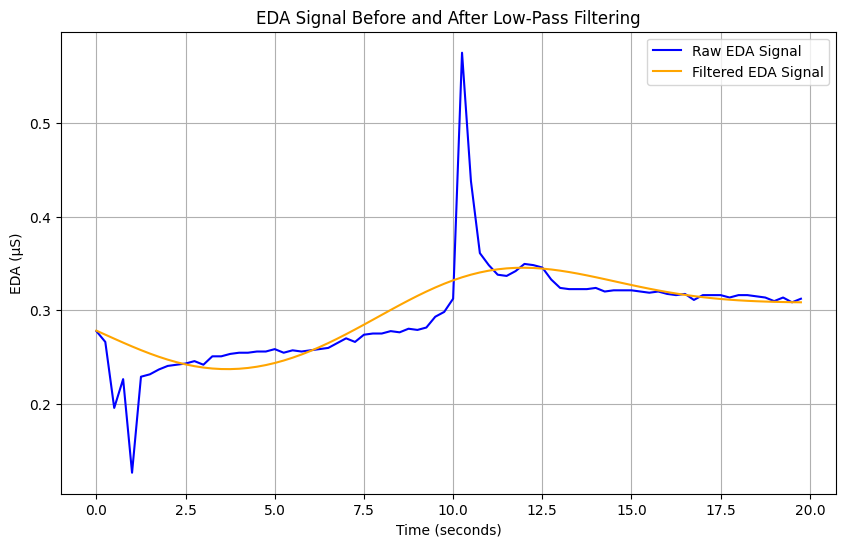

Saved EDA Signal Plot to /kaggle/working/outputs/eda_signal.png


In [7]:

print("\nPlotting EDA Signal Before and After Filtering (Plot 1/5):")

first_subject = os.listdir(DATASET_DIR)[0]
first_path = os.path.join(DATASET_DIR, first_subject, f"{first_subject}.pkl")
with open(first_path, 'rb') as file:
    data = pickle.load(file, encoding='latin1')
gsr_signal = data['signal']['wrist']['EDA']
raw_signal = np.squeeze(gsr_signal[:WINDOW_SIZE])
filtered_signal = low_pass_filter(raw_signal)
time = np.arange(0, len(raw_signal)) / 4  

plt.figure(figsize=(10, 6))
plt.plot(time, raw_signal, label='Raw EDA Signal', color='blue')
plt.plot(time, filtered_signal, label='Filtered EDA Signal', color='orange')
plt.title('EDA Signal Before and After Low-Pass Filtering')
plt.xlabel('Time (seconds)')
plt.ylabel('EDA (µS)')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, 'eda_signal.png'))
plt.show()
plt.close()
print(f"Saved EDA Signal Plot to {os.path.join(OUTPUT_DIR, 'eda_signal.png')}")

# Plot Class Distribution Before and After SMOTE


Plotting Class Distribution Before and After SMOTE (Plot 2/5):


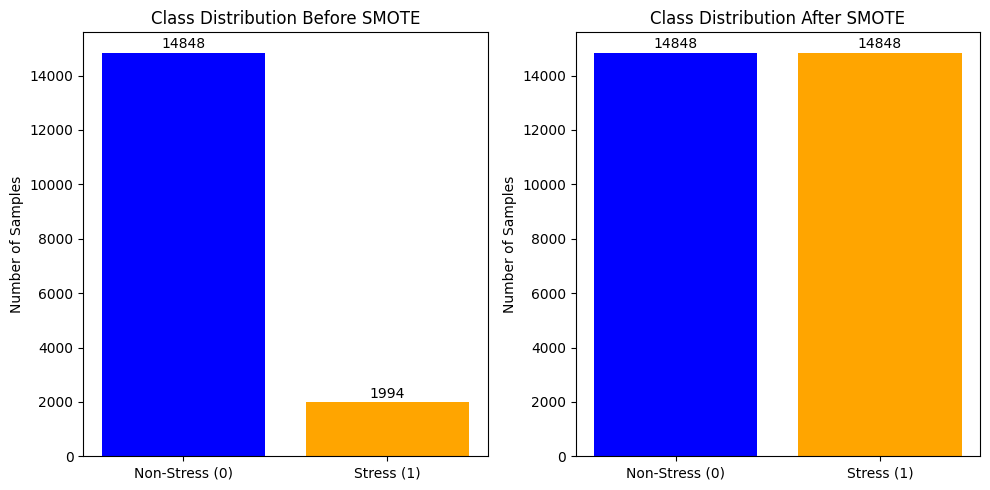

Saved Class Distribution Plot to /kaggle/working/outputs/class_distribution.png


In [8]:

print("\nPlotting Class Distribution Before and After SMOTE (Plot 2/5):")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Before SMOTE
non_stress_before = len(df[df['Label'] == 0])
stress_before = len(df[df['Label'] == 1])
ax1.bar(['Non-Stress (0)', 'Stress (1)'], [non_stress_before, stress_before], color=['blue', 'orange'])
ax1.set_title('Class Distribution Before SMOTE')
ax1.set_ylabel('Number of Samples')
for i, v in enumerate([non_stress_before, stress_before]):
    ax1.text(i, v + 50, str(v), ha='center', va='bottom')

# After SMOTE
non_stress_after = len(y[y == 0])
stress_after = len(y[y == 1])
ax2.bar(['Non-Stress (0)', 'Stress (1)'], [non_stress_after, stress_after], color=['blue', 'orange'])
ax2.set_title('Class Distribution After SMOTE')
ax2.set_ylabel('Number of Samples')
for i, v in enumerate([non_stress_after, stress_after]):
    ax2.text(i, v + 50, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'class_distribution.png'))
plt.show()
plt.close()
print(f"Saved Class Distribution Plot to {os.path.join(OUTPUT_DIR, 'class_distribution.png')}")

#  Confusion Matrix 
#  Plot Loss Curve


3. Training Accuracy: 0.9095
4. Test Accuracy: 0.8667

5. Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.85      4455
           1       0.82      0.95      0.88      4454

    accuracy                           0.87      8909
   macro avg       0.88      0.87      0.87      8909
weighted avg       0.88      0.87      0.87      8909


6. Confusion Matrix:
 [[3501  954]
 [ 234 4220]]

7. Displaying Confusion Matrix Plot (Plot 3/6):


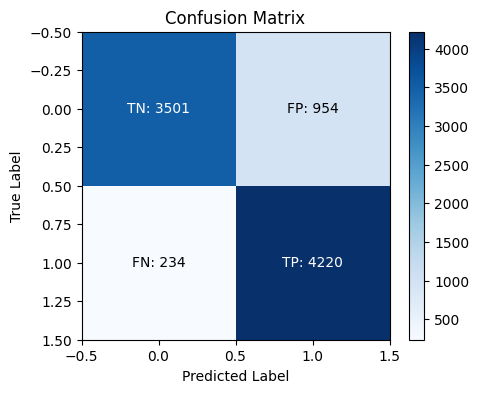


8. Displaying Loss Curve Plot (Plot 4/6):


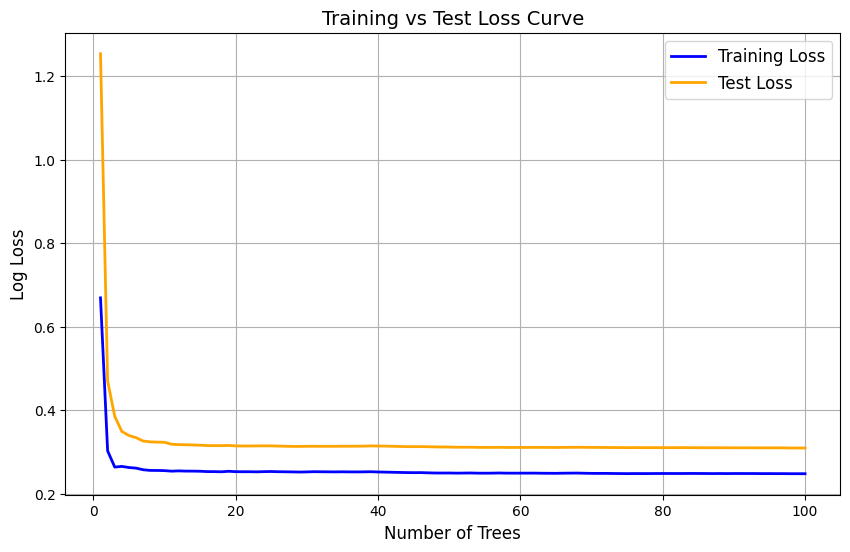

In [9]:
# 3. Training Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"\n3. Training Accuracy: {train_accuracy:.4f}")

# 4. Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"4. Test Accuracy: {test_accuracy:.4f}")

# 5. Classification Report
print("\n5. Classification Report:")
print(classification_report(y_test, y_test_pred))

# 6. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\n6. Confusion Matrix:\n", conf_matrix)

# 7. Plot Confusion Matrix
print("\n7. Displaying Confusion Matrix Plot (Plot 3/6):")
plt.figure(figsize=(5, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i == 0 and j == 0:
            plt.text(j, i, f'TN: {conf_matrix[i, j]}', ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')
        elif i == 0 and j == 1:
            plt.text(j, i, f'FP: {conf_matrix[i, j]}', ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')
        elif i == 1 and j == 0:
            plt.text(j, i, f'FN: {conf_matrix[i, j]}', ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')
        elif i == 1 and j == 1:
            plt.text(j, i, f'TP: {conf_matrix[i, j]}', ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
plt.show()
plt.close()

# 8. Plot Loss Curve
print("\n8. Displaying Loss Curve Plot (Plot 4/6):")
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(n_estimators_range, test_losses, label='Test Loss', color='orange', linewidth=2)
plt.title('Training vs Test Loss Curve', fontsize=14)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curve.png'))
plt.show()
plt.close()

#  Loss Analysis and 
#  Feature Statistics for Stressed and Non-Stressed Samples

In [10]:

final_train_loss = train_losses[-1]
final_test_loss = test_losses[-1]
print("\n9. Loss Analysis:")
if final_train_loss < final_test_loss and (final_test_loss - final_train_loss) < 0.5:
    print("The model shows good generalization. The training loss curve is consistently below the test loss curve, but the gap is not too large, indicating minimal overfitting.")
elif final_train_loss < final_test_loss and (final_test_loss - final_train_loss) >= 0.5:
    print("The model may be overfitting. The training loss curve is significantly lower than the test loss curve, suggesting the model fits the training data too closely.")
else:
    print("The model shows unusual behavior. The test loss curve is below the training loss curve, which is uncommon and may indicate issues with the data split or model configuration.")


stressed_df = df[df['Label'] == 1]
non_stressed_df = df[df['Label'] == 0]
print("\n10. Feature Statistics for Stressed Samples (Label = 1):")
print(stressed_df.describe())
print("\nFeature Statistics for Non-Stressed Samples (Label = 0):")
print(non_stressed_df.describe())


9. Loss Analysis:
The model shows good generalization. The training loss curve is consistently below the test loss curve, but the gap is not too large, indicating minimal overfitting.

10. Feature Statistics for Stressed Samples (Label = 1):
          Mean_GSR  Std_Dev_GSR      Min_GSR      Max_GSR     Skewness  \
count  1994.000000  1994.000000  1994.000000  1994.000000  1994.000000   
mean      3.420167     0.057499     3.326839     3.518409     0.100298   
std       3.657900     0.070913     3.586869     3.725269     0.697751   
min       0.298680     0.000180     0.291693     0.299985    -2.692441   
25%       1.042049     0.014847     1.017046     1.068696    -0.284232   
50%       2.138313     0.032447     2.060978     2.221757     0.106673   
75%       3.912368     0.075612     3.737817     4.068113     0.485810   
max      15.672504     0.601133    15.561854    15.903501     2.636875   

          Kurtosis  Dominant_Frequency   Total_Power  Phasic_Mean  \
count  1994.000000   

#  GUI for Stress Prediction

In [11]:
# 11. GUI for Stress Prediction
feature_names = [
    "Mean GSR", "Std Dev GSR", "Min GSR", "Max GSR", 
    "Skewness", "Kurtosis", "Dominant Frequency", "Total Power",
    "Phasic Mean", "Phasic Std", "SCR Count",
    "Power 0-0.1Hz", "Power 0.1-0.2Hz", "Power 0.2-0.4Hz"
]

# Create input widgets for the feature values
input_widgets = [widgets.FloatText(
    description=name + ":", 
    value=0.0, 
    style={'description_width': 'initial'},
    layout={'width': '400px'}
) for name in feature_names]

# Create a button to trigger prediction
predict_button = widgets.Button(
    description="Predict Stress",
    button_style='success',
    tooltip='Click to predict stress level',
    layout={'width': '200px', 'margin': '10px 0'}
)

# Create an output widget to display the result
output = widgets.Output()

# Define the prediction function
def on_predict_button_clicked(b):
    with output:
        output.clear_output()
        if len(np.unique(y)) <= 1:
            display(HTML("<p style='color: #e74c3c;'>Error: Model not trained (only one class detected in the dataset).</p>"))
            return
        
        # Collect input values
        input_values = []
        for widget in input_widgets:
            try:
                value = float(widget.value)
                input_values.append(value)
            except ValueError:
                display(HTML(f"<p style='color: #e74c3c;'>Invalid input for {widget.description}. Please enter a valid number.</p>"))
                return
        
        # Create a DataFrame with feature names to match training
        features = pd.DataFrame([input_values], columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
        
        try:
            # Scale the features
            scaled_features = scaler.transform(features)
            # Make prediction
            prediction = model.predict(scaled_features)[0]
            probability = model.predict_proba(scaled_features)[0]
            
            # Determine result and confidence
            result = "Stressed" if prediction == 1 else "Not Stressed"
            confidence = probability[1] if prediction == 1 else probability[0]
            
            # Display styled result
            color = "#e74c3c" if prediction == 1 else "#2ecc71"
            display(HTML(f"""
                <div style='background-color: #f5f5f5; padding: 15px; border-radius: 5px;'>
                    <h3 style='color: {color}; margin: 0;'>Prediction: {result}</h3>
                    <p style='color: #333; margin: 5px 0 0 0;'>Confidence: {confidence:.2%}</p>
                </div>
            """))
        except Exception as e:
            display(HTML(f"<p style='color: #e74c3c;'>Error in prediction: {str(e)}</p>"))

# Connect the button to the prediction function
predict_button.on_click(on_predict_button_clicked)

# Display the GUI
print("\n11. Displaying Stress Prediction GUI (5/6):")
display(HTML("""
    <h2 style='color: #2c3e50;'>Stress Prediction GUI</h2>
    <p style='color: #34495e;'>Enter the GSR feature values below and click 'Predict Stress' to see the result.</p>
"""))
for widget in input_widgets:
    display(widget)
display(predict_button)
display(output)


11. Displaying Stress Prediction GUI (5/6):


FloatText(value=0.0, description='Mean GSR:', layout=Layout(width='400px'), style=DescriptionStyle(description…

FloatText(value=0.0, description='Std Dev GSR:', layout=Layout(width='400px'), style=DescriptionStyle(descript…

FloatText(value=0.0, description='Min GSR:', layout=Layout(width='400px'), style=DescriptionStyle(description_…

FloatText(value=0.0, description='Max GSR:', layout=Layout(width='400px'), style=DescriptionStyle(description_…

FloatText(value=0.0, description='Skewness:', layout=Layout(width='400px'), style=DescriptionStyle(description…

FloatText(value=0.0, description='Kurtosis:', layout=Layout(width='400px'), style=DescriptionStyle(description…

FloatText(value=0.0, description='Dominant Frequency:', layout=Layout(width='400px'), style=DescriptionStyle(d…

FloatText(value=0.0, description='Total Power:', layout=Layout(width='400px'), style=DescriptionStyle(descript…

FloatText(value=0.0, description='Phasic Mean:', layout=Layout(width='400px'), style=DescriptionStyle(descript…

FloatText(value=0.0, description='Phasic Std:', layout=Layout(width='400px'), style=DescriptionStyle(descripti…

FloatText(value=0.0, description='SCR Count:', layout=Layout(width='400px'), style=DescriptionStyle(descriptio…

FloatText(value=0.0, description='Power 0-0.1Hz:', layout=Layout(width='400px'), style=DescriptionStyle(descri…

FloatText(value=0.0, description='Power 0.1-0.2Hz:', layout=Layout(width='400px'), style=DescriptionStyle(desc…

FloatText(value=0.0, description='Power 0.2-0.4Hz:', layout=Layout(width='400px'), style=DescriptionStyle(desc…

Button(button_style='success', description='Predict Stress', layout=Layout(margin='10px 0', width='200px'), st…

Output()